In [5]:
import sys
work_path = "/home/haselab/Documents/tat/Research/"
sys.path.append(f"{work_path}app/torch_libs/")

from run_manager_new import RunManager, RunsManager, RunViewer

rv = RunViewer(exp_path="./")
rv.write_stats()


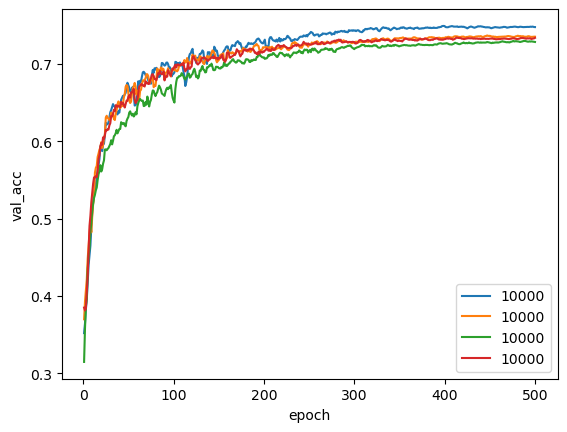

In [6]:
import polars as pl
import matplotlib.pyplot as plt

rv = RunViewer(exp_path="./")
rv.write_stats()

df_stats = rv.fetch_stats()
df_stats_ext = df_stats.filter((pl.col("fils") == 1) & (pl.col("num_data") == 10000))
run_ids = df_stats_ext["run_id"]

df_mets = rv.fetch_metrics()
df_agg = df_mets.group_by(by="run_id", maintain_order=True).agg(pl.all())
df_agg = df_agg.filter((pl.col("run_id").is_in(run_ids)))


x_col = "epoch"
y_col = "val_acc"
label_col = "num_data"


fig, ax = plt.subplots(nrows=1, ncols=1, squeeze=False)

ax[0][0].set_xlabel(x_col)
ax[0][0].set_ylabel(y_col)

for df_row in df_agg.iter_rows(named=True):
    x = pl.Series(df_row[x_col])
    y = pl.Series(df_row[y_col]).rolling_mean(window_size=4, min_periods=0)
    label = df_stats.filter(pl.col("run_id") == df_row["run_id"])[label_col][0]

    ax[0][0].plot(x, y, label=label)

ax[0][0].legend()



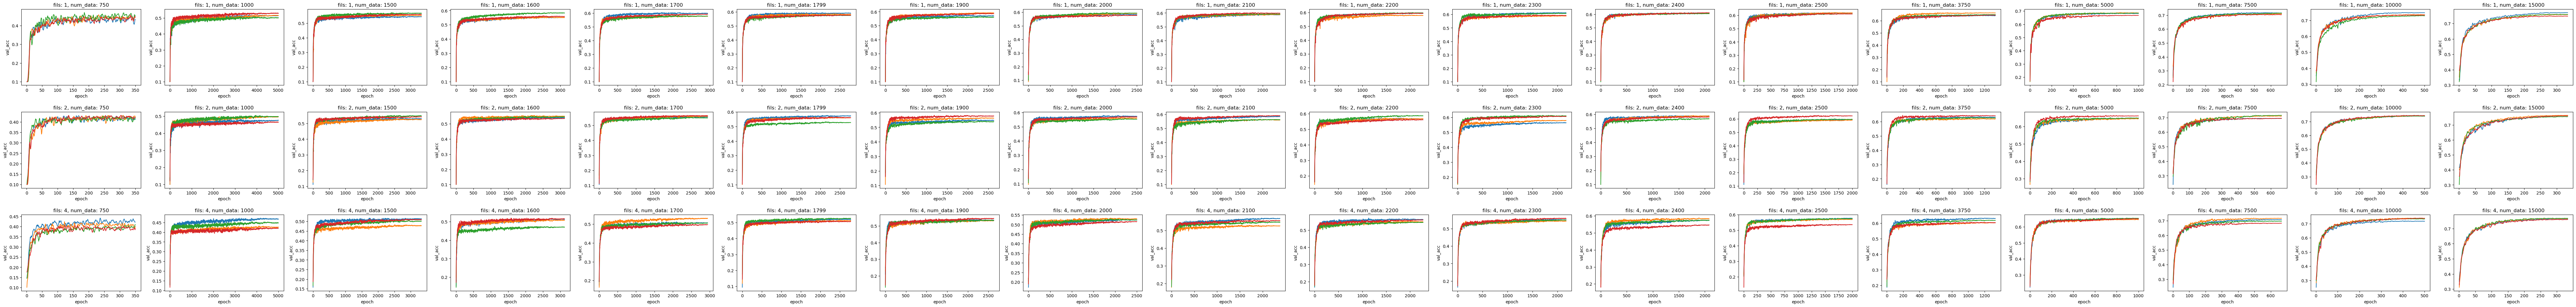

In [7]:
def rv_to_figs(rv, place_row_col, place_col_col, graph_x_col, graph_y_col, label_col, window_size=None):
    df_stats = rv.fetch_stats()
    df_mets = rv.fetch_metrics()

    row_vals = df_stats[place_row_col].unique()
    col_vals = df_stats[place_col_col].unique()

    fig, ax = plt.subplots(nrows=len(row_vals), ncols=len(col_vals), squeeze=False)
    plt.subplots_adjust(hspace=0.35)
    fig.set_figwidth(6 * len(col_vals))
    fig.set_figheight(4 * len(row_vals))

    for r, row_val in enumerate(row_vals):
        for c, col_val in enumerate(col_vals):

            df_stats_ext = df_stats.filter((pl.col(place_row_col) == row_val) & (pl.col(place_col_col) == col_val))
            run_ids = df_stats_ext["run_id"]

            df_agg = df_mets.group_by(by="run_id", maintain_order=True).agg(pl.all())
            df_agg = df_agg.filter((pl.col("run_id").is_in(run_ids)))

            ax[r][c].set_xlabel(graph_x_col)
            ax[r][c].set_ylabel(graph_y_col)
            ax[r][c].set_title(f"{place_row_col}: {row_val}, {place_col_col}: {col_val}")

            for df_row in df_agg.iter_rows(named=True):
                x = pl.Series(df_row[graph_x_col])
                y = pl.Series(df_row[graph_y_col]).rolling_mean(window_size=window_size, min_periods=0)
                # label = df_stats.filter(pl.col("run_id") == df_row["run_id"])[label_col][0]
                # ax[r][c].plot(x, y, label=label)
                ax[r][c].plot(x, y)
                # ax[r][c].legend()


rv = RunViewer(exp_path="./")
rv_to_figs(rv, "fils", "num_data", "epoch", "val_acc", "num_data", window_size=4)


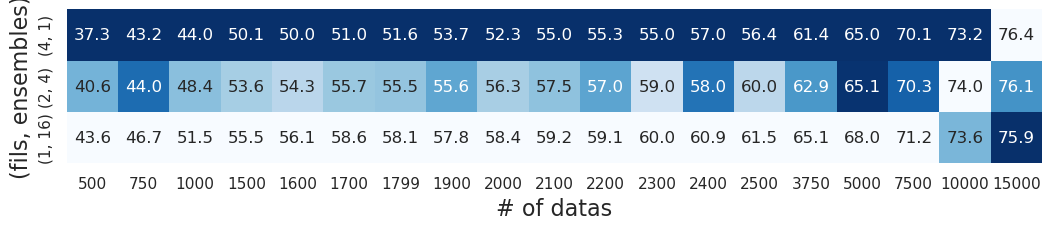

In [12]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def heat_pivot(df, values, index, columns, aggregate_function=None, cmap=None, xlabels=None, ylabels=None, annot_rescale=False, color_rescale=False):
    df = df.sort(columns)
    df = df.pivot(values=values, index=index, columns=columns, aggregate_function=aggregate_function)
    df = df.reverse()
    # df = df.select(df.columns[::-1])
    df_ind_ser= df.select(index).to_series()
    df = df.select(pl.all().exclude(index))

    if xlabels is None:
        xlabels = df.columns
    if ylabels is None:
        ylabels = df_ind_ser
    
    def rescale(df):
        for col_name in df.columns:
            col_ser = df[col_name]
            max_val = col_ser.max()
            min_val = col_ser.min()

            df = df.with_columns(pl.col(col_name).sub(min_val).truediv(max_val - min_val))
        return df

    re_df = rescale(df)
    

    def col_prop(df):
        for col_name in df.columns:
            col_ser = df[col_name]
            sum_val = col_ser.sum()

            df = df.with_columns(pl.col(col_name).truediv(sum_val))
        return df

    prop_df = col_prop(re_df)

    prop_df = (prop_df * df_ind_ser).sum()
    
    # prop_df.write_csv("./prop.csv")
    # tmp = prop_df.row(0)
    # tmp2 = []
    # for t in tmp: tmp2.append(t*-1)
    # plt.figure(figsize=(14, 4))
    # plt.plot(prop_df.columns, tmp2)
    # plt.show()
    

    if annot_rescale:
        annot_C = re_df.to_numpy()
    else:
        annot_C = df.to_numpy()

    if color_rescale:
        color_C = re_df.to_numpy()
    else:
        color_C = df.to_numpy()
    
    annot_C *= 100



    sns.set(rc={"figure.figsize": (len(xlabels)/1.5, len(ylabels)/1.5)})
    # sns.set(rc={"figure.figsize": (20, 20)})
    ax = sns.heatmap(color_C, annot=annot_C, cbar=False, square=True, cmap=cmap, xticklabels=xlabels, yticklabels=ylabels, fmt=".1f")
    # ax = sns.heatmap(color_C, annot=annot_C, cbar=False, square=True, cmap=cmap, xticklabels=xlabels, yticklabels=ylabels)
    ax.set_xlabel("# of datas", fontsize=16)
    # ax.set_ylabel("fils", fontsize=16)
    ax.set_ylabel("(fils, ensembles)", fontsize=16)
    plt.show()


rv = RunViewer(exp_path="./")
rv.write_stats()
df_stats = rv.fetch_stats()
df_stats_ext = df_stats

# df_stats_ext = df_stats_ext.filter(pl.col("fils").is_in([2, 4, 8, 16, 32, 64]))
# df_stats_ext = df_stats_ext.filter(pl.col("num_data") >= 125)

a = df_stats_ext["fils"].unique().sort(descending=True)
b = df_stats_ext["ensembles"].unique().sort()

t = [(a, b) for a, b in zip(a, b)]

df_stats = df_stats.with_columns((pl.col("fils").cast(pl.Utf8) + pl.lit(", ") + pl.col("ensembles").cast(pl.Utf8)).alias("fils_ensembles"))
heat_pivot(df_stats, values="val_acc", index="fils", columns="num_data", cmap="Blues_r", ylabels=t, aggregate_function="mean", annot_rescale=False, color_rescale=True)


